# Introduction

In the first two parts of this Data Science project, we explored the "Brazilian E-Commerce Public Dataset by Olist" and worked on manipulating and visualizing the data. Now, in the third and final part, our goal is to predict customer satisfaction based on the review score using machine learning models.

Based on the variables we identified in the first part as relevant to customer satisfaction and the visualizations created in the second part, we will train different machine learning models to predict customer satisfaction based on the available information.

In this step, we will use data preprocessing, cross-validation, and hyperparameter optimization techniques to ensure that our models are fit and optimized for the given dataset.

Importantly, the previous stages of this project have been critical in getting us this far. In the [first part](https://www.kaggle.com/code/gustavofelici/sql-mining-for-features-to-predict-order-score), we understood the context of the data and identified the most important variables for customer satisfaction. In the [second part](https://www.kaggle.com/code/gustavofelici/data-cleaning-and-analysis-uncovering-patterns), we cleaned and organized the data, created visualizations, and better understood the relationships between the variables.

Now, in the third part, we will use everything we learned to predict customer satisfaction based on the review score. We hope that this work can contribute to a better understanding of the customer experience in Brazilian e-commerce and to the continuous improvement of the services offered by Olist.

## Initial Hypothesis, what is a good model for this case?
The proportion of scores 1 and 2 should be similar, since they indicate the occurrence of a major problem that justifies evaluation at these levels. Therefore, they should not be classified as different classes. Score 3, indicating a less severe problem, may be confused with other classes. Score 4, being a small problem, should have a higher probability of being identified as score 4 or 5, while score 5 indicates that everything went well and should not be confused with other scores. For a machine learning algorithm, a good confusion matrix would be the one that classifies scores 1 and 2 as 1 and 2, divides score 3 among classes and classifies scores 4 and 5 as 4 and 5, respectively.

# Libraries

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

np.random.seed(0)
sns.set_theme(style="darkgrid", palette="viridis")

from sklearn.model_selection import RepeatedKFold, cross_validate, train_test_split, GridSearchCV

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler, StandardScaler, MinMaxScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_transformer

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from lightgbm import LGBMClassifier

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, recall_score, precision_score, f1_score, make_scorer

import time

# Importing Features
Let's make an initial model with the variables and using a simple model, to get initial results and understand more about the model

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/Data Science/Projects/Olist/Output/Olist_model_V2.csv')
data.head()

,Unnamed: 0,payment_installments_max,payment_value_mean,score,freight_value_mean,product_name_lenght_sum,product_name_lenght_mean,product_description_lenght_sum,product_photos_qty_sum,product_weight_g_sum,...,order_estimated_delivery_date_day,order_estimated_delivery_date_week,shipping_limit_date_max_day,shipping_limit_date_max_week,purchase_to_approved,approved_to_carrier,carrier_to_customer,estimated_to_customer,limit_to_carrier,pay_type__boleto
0,0,0,12.903333,4.0,8.72,40.0,40.0,268.0,4.0,500.0,...,18,3,6,5,0,2,4,-5,-2,0
1,1,0,141.460000,4.0,22.76,29.0,29.0,178.0,1.0,400.0,...,13,1,30,1,1,0,8,-4,-2,1
2,2,1,179.120000,5.0,19.22,46.0,46.0,232.0,1.0,420.0,...,4,2,13,1,0,0,7,-12,-3,0
3,3,0,72.200000,5.0,27.20,59.0,59.0,468.0,3.0,450.0,...,15,5,23,4,0,3,7,-10,-1,0
4,4,0,28.620000,5.0,8.72,38.0,38.0,316.0,4.0,250.0,...,26,1,19,1,0,1,2,-6,-3,0


In [ ]:
data = data.drop('Unnamed: 0', axis=1)

In [ ]:
data.shape

(76913, 39)

# Sub Sampling
The subsample technique is a sampling technique that consists of randomly selecting a portion of the original data to be used in an analysis. The goal is to reduce the size of the data, making the analysis faster and reducing the possibility of overfitting. Subsampling can be done randomly, stratified, or using other selection techniques. This technique is widely used in several areas, such as data analysis, machine learning, and statistics, because it allows a more efficient and accurate analysis of the available data. However, it is important to be careful not to lose important information from the original data when applying the subsample technique.

<Axes: xlabel='score', ylabel='count'>

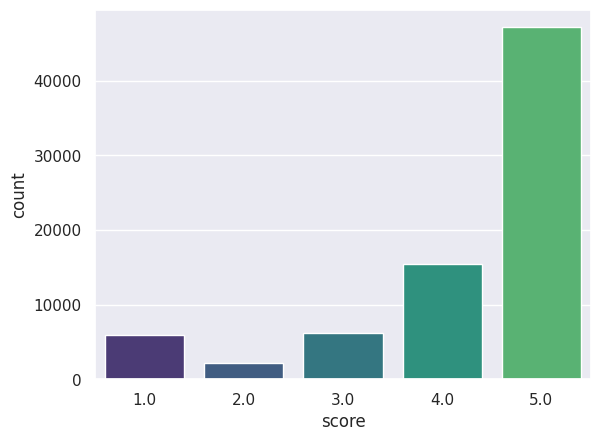

In [ ]:
sns.countplot(data=data, x='score')

In [ ]:
pd.concat([data.score.value_counts(), round(data.score.value_counts(normalize=True)*100, 2)], axis=1)

,score,score
5.0,47137,61.29
4.0,15491,20.14
3.0,6237,8.11
1.0,5925,7.70
2.0,2123,2.76


In [ ]:
#four_samples = int( (data.score == 4).sum() * 0.5 )
#five_samples = int( (data.score == 5).sum() * 0.2 )

four_samples = 6237
five_samples = 6237

four_scored_sample = data[ data.score == 4].sample(four_samples)
five_scored_sample = data[ data.score == 5].sample(five_samples)
data_other_scores = data[ data.score < 4 ]

df = pd.concat([data_other_scores, four_scored_sample, five_scored_sample]).reset_index(drop=True)

<Axes: xlabel='score', ylabel='count'>

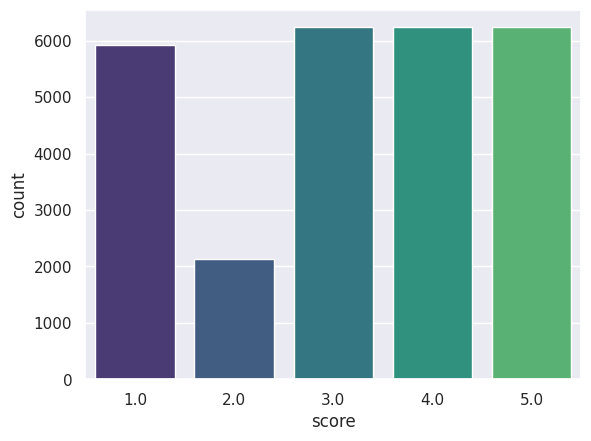

In [ ]:
sns.countplot(data=df, x='score')

In [ ]:
pd.concat([df.score.value_counts(), round(df.score.value_counts(normalize=True) * 100, 2)], axis=1)

,score,score
3.0,6237,23.31
4.0,6237,23.31
5.0,6237,23.31
1.0,5925,22.14
2.0,2123,7.93


In [ ]:
df.shape

(26759, 39)

In [ ]:
X = df.drop('score', axis=1)
y = (df['score'] - 1).astype(int)

In [ ]:
continuous_vars = ['product_photos_qty_sum',
 'approved_to_carrier',
 'limit_to_carrier',
 'carrier_to_customer',
 'estimated_to_customer',
 'product_width_cm_sum',
 'product_height_cm_sum',
 'product_name_lenght_mean',
 'product_width_cm_mean',
 'product_length_cm_sum',
 'product_height_cm_mean',
 'product_length_cm_mean',
 'product_name_lenght_sum',
 'product_weight_g_sum',
 'product_description_lenght_sum',
 'freight_value_mean',
 'payment_value_mean',
 'distance_km_sum']

# First Model

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [ ]:
preprocessor = make_column_transformer((StandardScaler(), continuous_vars), remainder='passthrough')

In [ ]:
model = make_pipeline(preprocessor, LGBMClassifier())
model.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  ['product_photos_qty_sum',
                                                   'approved_to_carrier',
                                                   'limit_to_carrier',
                                                   'carrier_to_customer',
                                                   'estimated_to_customer',
                                                   'product_width_cm_sum',
                                                   'product_height_cm_sum',
                                                   'product_name_lenght_mean',
                                                   'product_width_cm_mean',
                                                   'product_length_cm_sum',
                                                   'product_height_cm_mean',
                                                   'product_length_cm_mean',
                                                   'product_name_lenght_sum',
                                                   'product_weight_g_sum',
                                                   'product_description_lenght_sum',
                                                   'freight_value_mean',
                                                   'payment_value_mean',
                                                   'distance_km_sum'])])),
                ('lgbmclassifier', LGBMClassifier())])

## Results

In [ ]:
y_pred = model.predict(X_test)

metrics = {
    'Accuracy': accuracy_score(y_pred, y_test),
    'F1': f1_score(y_pred, y_test, average = 'macro'),
    'Recall': recall_score(y_pred, y_test, average = 'macro', zero_division=0),
    'Precision': precision_score(y_pred, y_test, average = 'macro')
}

{key: round(value, 4) for key, value in metrics.items()}

{'Accuracy': 0.3302, 'F1': 0.2814, 'Recall': 0.3075, 'Precision': 0.2894}

## Matrix

In [ ]:
y_test = y_test + 1
y_pred = y_pred + 1

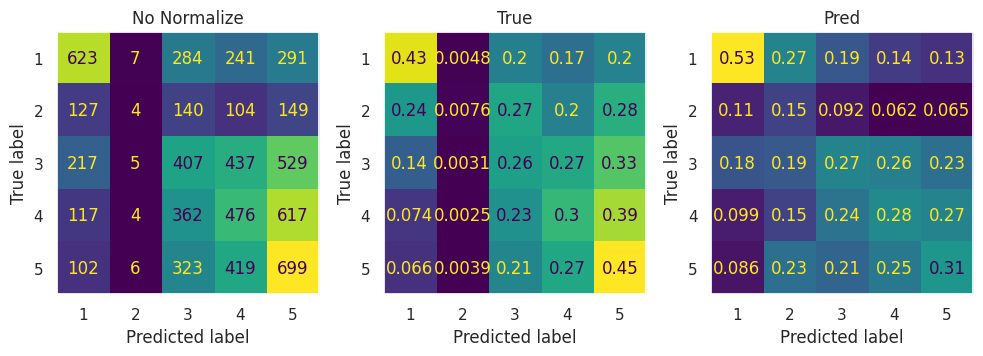

In [ ]:
fig, ax = plt.subplots(ncols=3, figsize=(10,4))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, ax=ax[0], colorbar=False)
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, normalize='true', colorbar=False,  ax=ax[1])
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, normalize='pred', colorbar=False, ax=ax[2])

ax[0].set_title('No Normalize')
ax[0].grid(False)

ax[1].set_title('True')
ax[1].grid(False)

ax[2].set_title('Pred')
ax[2].grid(False)

fig.tight_layout()
plt.show()

It had a good result, very similar to our hypothesis, but class 2 was very confusing, there is no way to be sure of the definition of class 2, because the result is very similar to all the others.

# Feature Importance

In [ ]:
# feature importance dataframe
importances = model.named_steps['lgbmclassifier'].feature_importances_
feature_importances = pd.DataFrame({'column': X.columns, 'importance': importances})

# Order By importance
feature_importances = feature_importances.sort_values(by='importance', ascending=False).reset_index(drop=True)
feature_importances

,column,importance
0,order_purchase_timestamp_day,877
1,same_state_mean,869
2,order_purchase_timestamp_hour,836
3,distance_km_sum,771
4,product_name_lenght_mean,681
5,product_width_cm_mean,628
6,purchase_to_approved,538
7,shipping_limit_date_max_day,520
8,product_name_lenght_sum,495
9,order_delivered_customer_date_day,486


In [ ]:
feature_importances.importance.describe()

count     38.000000
mean     394.736842
std      222.852961
min        0.000000
25%      256.750000
50%      410.000000
75%      485.750000
max      877.000000
Name: importance, dtype: float64

In [ ]:
#threshold = round(feature_importances.importance.mean(), 2)
threshold = 200

print('threshold >=', threshold)
threshold_importances = feature_importances[ feature_importances.importance >= threshold]
threshold_importances

threshold >= 200


,column,importance
0,order_purchase_timestamp_day,877
1,same_state_mean,869
2,order_purchase_timestamp_hour,836
3,distance_km_sum,771
4,product_name_lenght_mean,681
5,product_width_cm_mean,628
6,purchase_to_approved,538
7,shipping_limit_date_max_day,520
8,product_name_lenght_sum,495
9,order_delivered_customer_date_day,486


## Re-modeling

In [ ]:
df = df[['score'] + list(threshold_importances.column)]

In [ ]:
continuous_vars = [i for i in df.columns if i in continuous_vars]
continuous_vars

['distance_km_sum',
 'product_name_lenght_mean',
 'product_width_cm_mean',
 'product_name_lenght_sum',
 'product_weight_g_sum',
 'carrier_to_customer',
 'product_width_cm_sum',
 'product_photos_qty_sum',
 'product_length_cm_mean',
 'product_height_cm_mean',
 'product_description_lenght_sum',
 'product_length_cm_sum',
 'payment_value_mean',
 'estimated_to_customer',
 'product_height_cm_sum',
 'freight_value_mean',
 'approved_to_carrier']

In [ ]:
preprocessor = make_column_transformer((StandardScaler(), continuous_vars), remainder='passthrough')

In [ ]:
X = df.drop('score', axis=1)
y = (df['score'] - 1).astype(int)

# Algorithms Testing
Let's understand between several algorithms to see which performs best

## Functions

In [ ]:
algorithms = {
    'Decision Tree': DecisionTreeClassifier(),
    'Naive Bayes': GaussianNB(),
    'KNN': KNeighborsClassifier(),
    'Random Forest': RandomForestClassifier(),
    'XGB': XGBClassifier(),
    'LGBM': LGBMClassifier(),
    'GBC' : GradientBoostingClassifier()
}

In [ ]:
def matrix_algorithms(X, y):
  n = len(algorithms)
  fig, axs = plt.subplots(3, n, figsize=(30,12))
  axs = axs.ravel()
  i=0
  X_train, X_test, y_train, y_test = train_test_split(X, y)
    
  for key, algorithm in algorithms.items():

    model = make_pipeline(preprocessor, algorithm)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    ConfusionMatrixDisplay.from_predictions(y_test+1, y_pred+1, ax=axs[i], colorbar=False)
    ConfusionMatrixDisplay.from_predictions(y_test+1, y_pred+1, ax=axs[i + n], colorbar=False, normalize='pred')
    ConfusionMatrixDisplay.from_predictions(y_test+1, y_pred+1, ax=axs[i + (n*2)], colorbar=False, normalize='true')

    acc = round(np.mean(y_test == y_pred) * 100, 2)
    f1 = round(f1_score(y_pred, y_test, average = 'macro'), 2)

    axs[i].set_title(f'{key} ({acc}) ({f1})' )
    axs[i].grid(False)

    axs[i + n].set_title(f'{key}: Pred')
    axs[i + n].grid(False)

    axs[i + (n*2)].set_title(f'{key}: True')
    axs[i + (n*2)].grid(False)
    i+=1

  fig.tight_layout()

In [ ]:
def test_algorithms(X,y):
  # Fit Algorithms
  result = pd.DataFrame()
  cv = RepeatedKFold(n_splits=5, n_repeats=3)
  
  scoring = {'accuracy': 'accuracy',
            'precision': make_scorer(precision_score, average='macro', zero_division=0),
            'recall': 'recall_macro',
            'f1': 'f1_macro'}

  for key, algorithm in algorithms.items():
    start_time = time.time()
    print(f'{key}...', end = '')
    model = make_pipeline(preprocessor, algorithm)

    cv_results = cross_validate(model, X, y, cv=cv, scoring=scoring, return_estimator =True)

    total_time = round((time.time() - start_time) / 60, 2)
    f1 = round(np.mean(cv_results["test_f1"]), 4)
    acc = round(np.mean(cv_results["test_accuracy"]), 4)

    new_row = {
        'Algorithm': key,
        'F1': f1,
        'Accuracy': acc,
        'Recall': round(np.mean(cv_results['test_recall']) , 4),
        'Precision': round(np.mean(cv_results['test_precision']), 4),
        'run_time': total_time,
        'model': cv_results['estimator']
      }

    

    result = pd.concat([result, pd.Series(new_row)], axis=1)
    print(f'finished!!! {total_time} min(s). F1: {f1}. Accuracy: {acc}')

  result = result.transpose().sort_values(by='F1', ascending=False).set_index('Algorithm', drop=True)
  print(f'Execution Time: {round(result["run_time"].sum(), 2)}  min(s).')
  return result

## Comparison

### Analysis of the normalized values
*Normalizing the confusion matrix will help us answer the following questions*
* Pred (Vertical or Columns): Where are the predictions for each class concentrated?
* True (Horizontal or Rows): Where are the true values for each class concentrated?

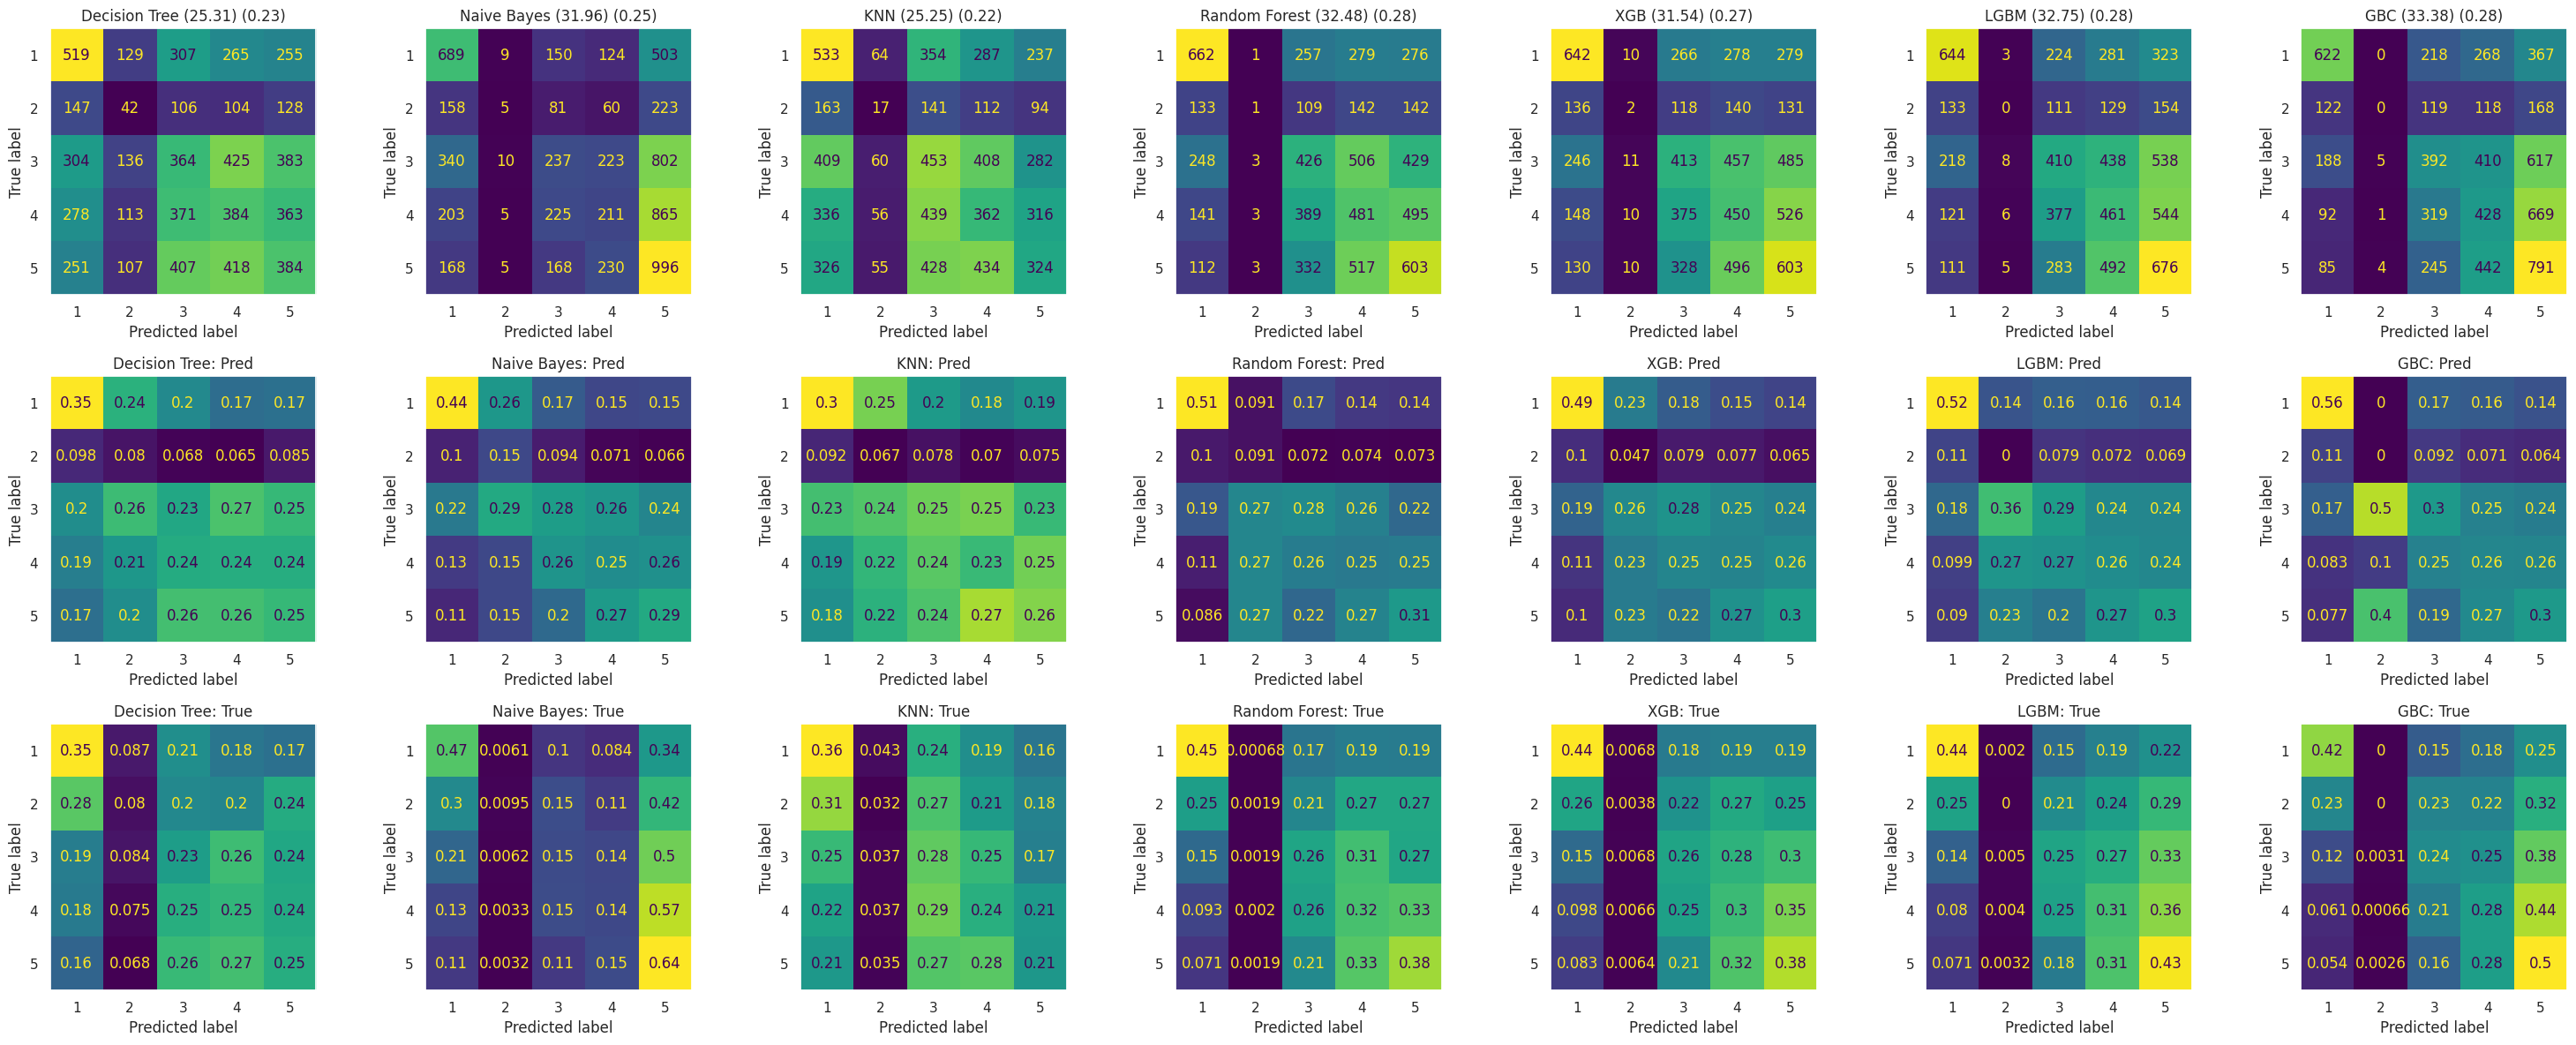

In [ ]:
matrix_algorithms(X, y)

Based on the confusion matrices of the analyzed algorithms, we can observe some important conclusions. The **Decision Tree** algorithm had difficulties defining class 1, due to the similar distribution of values among the classes. Classes 3 and 4 also had similar distributions, which prevented the algorithm from differentiating them clearly.

The **Naive Bayes** showed problems predicting class 1, with a large number of predictions concentrated in class 5. In addition, classes 2 to 5 were also mainly classified as 5, indicating low model reliability.

The **KNN** algorithm also showed similar difficulties to Naive Bayes, with class 1 tending to be classified at values smaller than 5, but with a very small trend. Again, class 5 was the class that concentrated most of the predictions from classes 2 to 5.

On the other hand, the **Random Forest**, **XGB**, **LGBM** and **GBC** algorithms had a good distinction between the classes. A trend was observed that class 1 should be classified mainly as 1, followed by 2 and 3. Random Forest showed the best prediction of class 1 and the lowest prediction of class 5, with few values predicted as 1. However, there was still a lot of confusion in predicting classes 2 and 3.

**We can conclude**, therefore, that among the analyzed algorithms, the **Random Forest** presented the best distinction between the classes, with a good prediction of class 1 and the least prediction of class 5. Although there was still some confusion in the predictions of classes 2 and 3, this algorithm proved to be the most reliable and accurate for the analyzed classification task.

In [ ]:
results = test_algorithms(X,y)

Decision Tree...finished!!! 0.19 min(s). F1: 0.2417. Accuracy: 0.2632
Naive Bayes...finished!!! 0.01 min(s). F1: 0.2493. Accuracy: 0.3184
KNN...finished!!! 0.24 min(s). F1: 0.2258. Accuracy: 0.2572
Random Forest...finished!!! 2.29 min(s). F1: 0.2754. Accuracy: 0.3236
XGB...finished!!! 6.51 min(s). F1: 0.2721. Accuracy: 0.3177
LGBM...finished!!! 0.67 min(s). F1: 0.2756. Accuracy: 0.3254
GBC...finished!!! 12.53 min(s). F1: 0.2791. Accuracy: 0.334
Execution Time: 22.44  min(s).


In [ ]:
results['run_time'].sum()

22.44

In [ ]:
columns = list(results.columns)
results[columns[:-2] ]

,F1,Accuracy,Recall,Precision
Algorithm,,,,
GBC,0.2791,0.334,0.2911,0.302
LGBM,0.2756,0.3254,0.2843,0.2989
Random Forest,0.2754,0.3236,0.2827,0.3049
XGB,0.2721,0.3177,0.2784,0.2881
Naive Bayes,0.2493,0.3184,0.2787,0.2742
Decision Tree,0.2417,0.2632,0.2417,0.2419
KNN,0.2258,0.2572,0.2296,0.2276


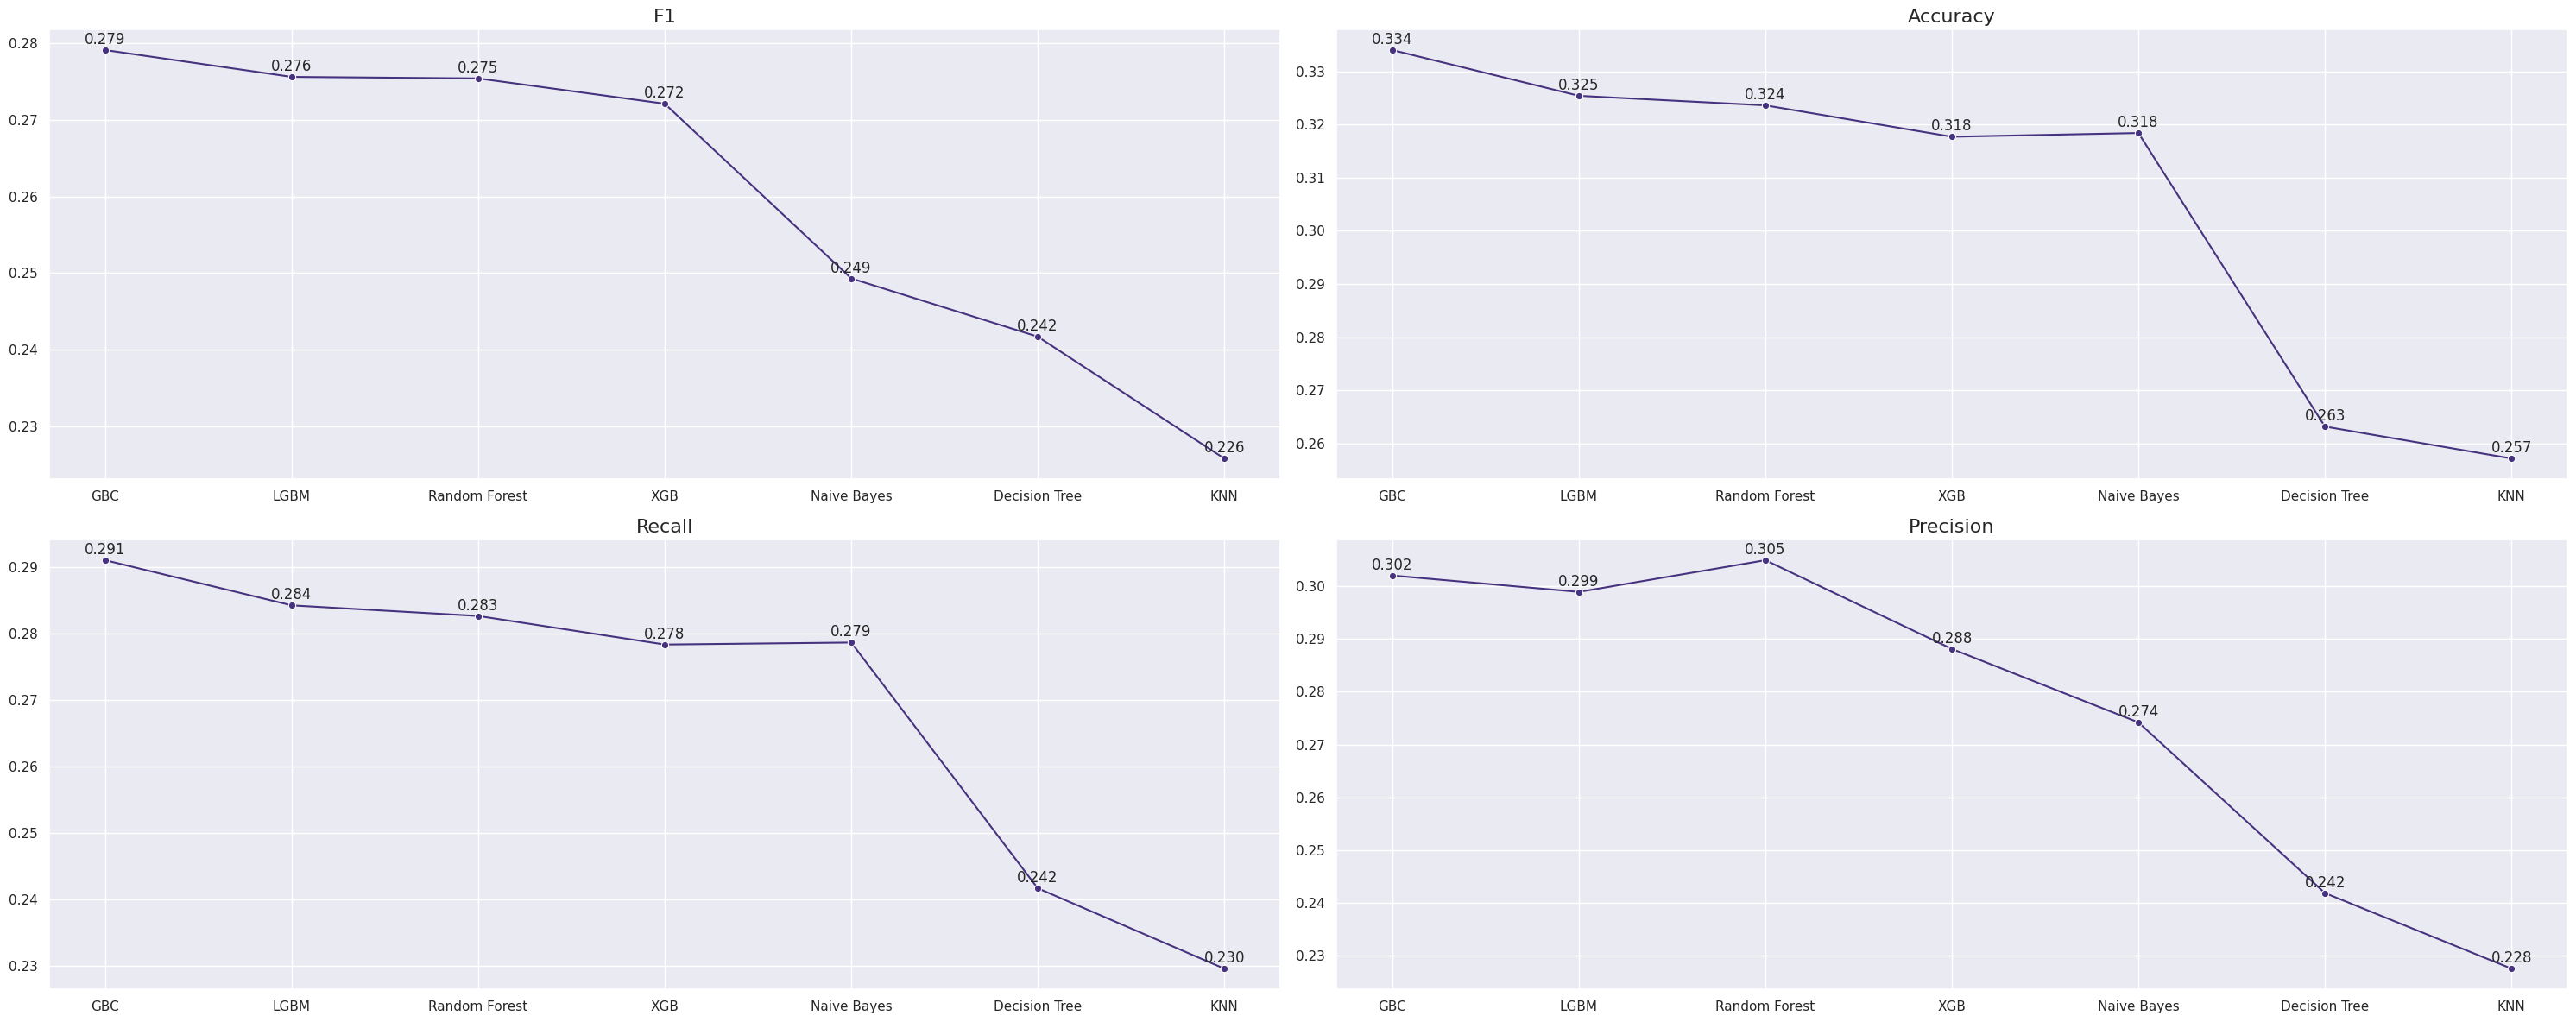

In [ ]:
columns = ['F1', 'Accuracy', 'Recall', 'Precision']
fig, axs = plt.subplots(2,2, figsize=(30,12))
axs = axs.ravel()

for i, col in enumerate(columns):
    sns.lineplot(data=results, 
                 x='Algorithm', 
                 y=col, 
                 marker='o', 
                 ax=axs[i])
    axs[i].set(xlabel='', ylabel='')
    axs[i].set_title(label =col, fontsize=16)
    for line in axs[i].lines:
        e_x, e_y = line.get_data()
        for e_xi, e_yi in zip(e_x, e_y):
            axs[i].annotate(format(e_yi, '.3f'), (e_xi, e_yi), textcoords='offset points', xytext=(0,5), ha='center')

plt.tight_layout()

# Conclusion
After performing the confusion matrix analysis and the results obtained using cross validate, we concluded that the Random Forest algorithm presented the best performance in classifying the data. Although the other algorithms have also presented good results, the Random Forest was able to present a greater distinction between the classes, especially for class 1, which presented a greater difficulty for the other algorithms. In addition, Random Forest showed a lower rate of wrong predictions for class 1, making it more reliable for this particular class. Although there was some confusion in the predictions for classes 2 and 3, the predictions were more balanced and did not tend to favor a particular class, which is a good feature. Therefore, based on the confusion matrix analysis, we can conclude that Random Forest is the best model for classifying the data in question.

Furthermore, to further improve the accuracy of Random Forest, the next steps would be to perform hyperparameter optimization to find the best combination of parameters that can improve the prediction. It would also be possible to simplify the data pipeline, leaving only the most important variables defined from feature importance analysis. This would make the prediction process simpler and faster.

I would like to thank everyone who has followed the project and I am available to answer any questions or doubts that may arise regarding the results or methodologies used. Any feedback or suggestions for improvement are also very welcome.